<a href="https://colab.research.google.com/github/varuntulsian2001/density_estimation_diffusion_models/blob/master/5.colab_EMNIST_conditional.diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating complex densities using Diffusion models

1. moving to alphabets and number generation using diffusion models
    * We will be using JAX
    * Using U-net blocks for modelling the denoising process

In [1]:
!pip install einops dm-haiku optax
!pip install dm-tree graphviz imageio[ffmpeg]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 79 kB/s 
     |████████████████████████████████| 352 kB 51.1 MB/s 
     |████████████████████████████████| 154 kB 14.6 MB/s 
     |████████████████████████████████| 85 kB 5.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [2]:
import haiku as hk
import jax
import jax.numpy as jnp
import einops
import math
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math
import os

colab = True

if not colab:
  os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
  jax.config.update('jax_platform_name', 'cpu')
Batch = Tuple[np.ndarray, np.ndarray]

In [3]:
if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
train_new_model = True
cont=False
model_name = 'emnist_fixed_with_cond.jax_version'

import os
import os.path as osp

if not colab:
  data_paths = osp.join(os.getcwd(), 'saved', 'saved_data')
  model_paths = osp.join(os.getcwd(), 'saved','saved_models')
  gifs_dir = osp.join(os.getcwd(), 'gifs')+"/"
  dataset_path = "/home/varun/tensorflow_datasets/"
else:
  data_paths = F"/content/gdrive/MyDrive/EMNIST/data/"
  model_paths = F"/content/gdrive/MyDrive/EMNIST/model/"
  gifs_dir = F"/content/gdrive/MyDrive/EMNIST/gifs/"
  dataset_path = F"/content/gdrive/MyDrive/EMNIST/dataset/"

In [5]:
# utils 
import pickle

def load_cached(filename):
    with open(filename, 'rb') as ff:
        return pickle.load(ff)
    
def write_cached(data, filename):
    with open(filename, 'wb') as ff:
        pickle.dump(data, ff, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# train model

# ####### i am not getting desired results with the cosine beta schedule from the hugging face repo
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = jnp.linspace(0, timesteps, steps)
    alphas_cumprod = jnp.cos(((x / timesteps) + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0.0001, 0.1)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = jnp.linspace(-6, 6, timesteps)
    return jnp.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [7]:
# Train model
timesteps = 200
# betas = linear_beta_schedule(timesteps)
betas = cosine_beta_schedule(timesteps)
alphas = 1 - betas
alphas_ = jnp.cumprod(alphas, axis=0)
variance = 1 - alphas_
sd = jnp.sqrt(variance)

alphas_prev_ = jnp.pad(alphas_[:-1], [1, 0], "constant", constant_values=1.0)
sigma_squared_q_t = (1 - alphas) * (1 - alphas_) / (1 - alphas_prev_)
log_sigma_squared_q_t = jnp.log(1-alphas) + jnp.log(1-alphas_) - jnp.log(1-alphas_prev_)
sigma_squared_q_t_corrected = jnp.exp(log_sigma_squared_q_t)
key = jax.random.PRNGKey(42)

# how to add noise to the data
@jax.jit
def get_noisy(rng, batch, timestep):
    timestep = einops.repeat(timestep, 'b -> b 28 28 1')
    # we will use the reparameterization trick
    # need to generate new keys everytime
    _, noise_key = jax.random.split(rng)
    noise_at_t = jax.random.normal(noise_key, shape=batch.shape)
    added_noise_at_t = jnp.add(batch * jnp.sqrt(alphas_[timestep]), noise_at_t * sd[timestep])
    return added_noise_at_t, noise_at_t

def recover_original(batch, timestep, noise):
    true_data = (batch.sub(noise.mul(sd[timestep]))).div(jnp.sqrt(alphas_[timestep]))
    return true_data

posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)

## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))

# not sure why we are multiplying by 1/2 here
posterior_variance_corrected = jnp.exp(log_posterior_variance)

([<matplotlib.lines.Line2D at 0x7f7f541137c0>],
 [<matplotlib.lines.Line2D at 0x7f7f540ec310>])

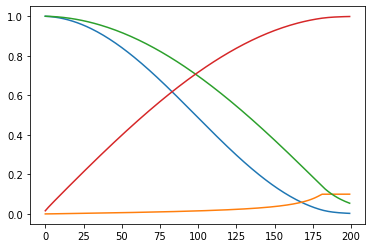

In [8]:
plt.plot(alphas_), plt.plot(posterior_variance_corrected), plt.plot(jnp.sqrt(alphas_)), plt.plot(sd)

In [9]:
EMNIST_MEAN = (0.13066373765468597)
EMNIST_STD = (0.30810782313346863)

# adapted from Optax loss -- https://github.com/deepmind/optax/blob/master/optax/_src/loss.py
@jax.jit
def huber_loss(
    predictions,
    targets= None,
    delta= 1.):
  """Huber loss, similar to L2 loss close to zero, L1 loss away from zero.
  If gradient descent is applied to the `huber loss`, it is equivalent to
  clipping gradients of an `l2_loss` to `[-delta, delta]` in the backward pass.
  References:
    [Huber, 1964](www.projecteuclid.org/download/pdf_1/euclid.aoms/1177703732)
  Args:
    predictions: a vector of arbitrary shape `[...]`.
    targets: a vector with shape broadcastable to that of `predictions`;
      if not provided then it is assumed to be a vector of zeros.
    delta: the bounds for the huber loss transformation, defaults at 1.
  Returns:
    elementwise huber losses, with the same shape of `predictions`.
  """
  errors = (predictions - targets) if (targets is not None) else predictions
  # 0.5 * err^2                  if |err| <= d
  # 0.5 * d^2 + d * (|err| - d)  if |err| > d
  abs_errors = jnp.abs(errors)
  quadratic = jnp.minimum(abs_errors, delta)
  # Same as max(abs_x - delta, 0) but avoids potentially doubling gradient.
  linear = abs_errors - quadratic
  return jnp.sum(0.5 * quadratic ** 2 + delta * linear, axis=(1, 2, 3))

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches."""
  # cache the dataset to memory and repeat it indefinitely, epochs have reshuffled ordered data since *reshuffle_each_iteration* defaults to TRUE
  ds = tfds.load('emnist', split=split, data_dir=dataset_path, as_supervised=True).cache().repeat()
  if is_training:
    # shuffle the batches to improve generalization of the trained network
    ds = ds.shuffle(400 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

# Recommended: this can be jit'd and it should result in faster training time 
@jax.jit
def compute_loss(params: hk.Params, batch: Batch, is_energy_method: bool=False) -> jnp.ndarray:
  """Compute the loss of the network, including L2."""
  x, label, timestep, noise = batch
  pred_data = net.apply(params, x, timestep, label)
  
  def error_func():
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (variance[timestep] * alphas[timestep]))
      # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(noise, pred_data)))
    return loss_
  
  def energy_func():
    ## Energy function interpretation
    imp_weight = 1.0 # 1/2 * (1/sigma_squared_q_t_corrected[timestep]) * ((betas[timestep])**2 / (alphas[timestep]))
    # loss on prediction
    loss_ = jnp.sum(jnp.multiply(imp_weight, huber_loss(pred_data, jnp.divide(noise, -sd[timestep]))))
    return loss_
    
  loss_ = jax.lax.cond(is_energy_method, energy_func, error_func)
  return loss_ 

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
    is_energy_method: bool=False
) -> Tuple[hk.Params, optax.OptState]:
  """Compute gradients and update the weights"""
  loss_value, grads = jax.value_and_grad(compute_loss)(params, batch, is_energy_method)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return loss_value, new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Incrementally update parameters via polyak averaging."""
  # Polyak averaging tracks an (exponential moving) average of the past parameters of a model, for use at test/evaluation time.
  return optax.incremental_update(params, avg_params, step_size=0.95)

@jax.jit
def normalize(images):
  # numpy array creation could be moved out of the method
  # mean = np.asarray(EMNIST_MEAN)
  # std = np.asarray(EMNIST_STD)

  # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  x = images.astype(jnp.float32) / 255.

  # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  # x -= mean  # operations uses numpy broadcasting to work correctly
  # x /= std 

  return x

@jax.jit
def unnormalize(images):
  # mean = np.asarray(EMNIST_MEAN)
  # std = np.asarray(EMNIST_STD)

  # # BUG 3: int8 range is -128 to 127 causing issues with numbers > 127, uint8 / 255. is float64, casting as float32 since that's the type jax prefers
  # x = images.astype(jnp.float32)

  # # BUG 4: x /- mean just divides x by -1. * mean without reassignment to x
  # x *= std 
  # x += mean  # operations uses numpy broadcasting to work correctly
  
  return images*255.
  

In [10]:
# using 20% of the dataset for training, 80% for validation, although it's weird to use maximum available data for validation
# BUG: using 80% train data, since performance improvement beyond 50% wasn't seen with 20% train data
batch_size=512
train = load_dataset("train+test", is_training=True, batch_size=batch_size)

In [11]:
%%capture 
# % matplotlib inline 
# to discard cell output

import matplotlib.animation as animation
import imageio 
from IPython.display import Image
from matplotlib.pyplot import figure

random_index = 22
image = next(train)[0][random_index]
fig = plt.figure()
ims = []
noisy_images, _ = get_noisy(key, einops.repeat(normalize(image), 'h w c -> b h w c', b=timesteps//10), jnp.arange(1, timesteps, 10))
if colab:
  noisy_images = einops.rearrange(noisy_images, 'b h w c -> b h (w c)')
noisy_images = unnormalize(noisy_images)

for i in range(timesteps//10):
    im = plt.imshow(noisy_images[i], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir+'diffusion.gif', writer='pillow')

def show_image(img, plt_):
  figure(figsize=(2, 2))
  if colab:
    img = einops.rearrange(img, 'h w c -> h (w c)')
  plt_.imshow(img, cmap="gray", animated=False)

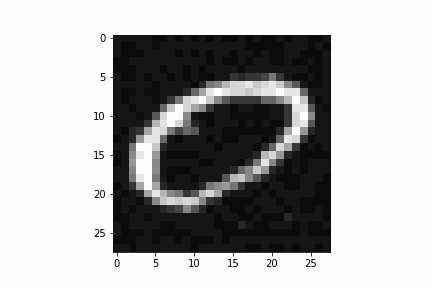

In [12]:
with open(gifs_dir + 'diffusion.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

In [13]:
# upsample operation in the UNET
class Downsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(4, 4), stride=2, padding=[1, 1])
  
  def __call__(self, x):
    return self.conv(x)
  
# Downsample operation in the UNET
class Upsample(hk.Module):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(3, 3), padding='SAME')
  
  def __call__(self, x):
    # scaling image to twice size
    x = einops.repeat(x, 'b h w c -> b (a h) (aa w) c', a=2, aa=2)
    return self.conv(x)
      
class TimeEmbeddings(hk.Module):
  def __init__(self, dim):
    super().__init__()
    half_dim = dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    self.embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)

  def __call__(self, timesteps):
      embeddings = self.embeddings
      embeddings = jnp.multiply(timesteps[:, None], embeddings[:, None].T)
      embeddings = jnp.hstack([jnp.sin(embeddings), jnp.cos(embeddings)])
      return embeddings

class Block(hk.Module):
  # a basic resnet style convolutional block
  def __init__(self, output_channels, kernel_size, padding):
    super().__init__()
    self.proj = hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME')
    self.ln = hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True)
    self.seq = hk.Sequential([
      jax.nn.silu,
      hk.Conv2D(output_channels=output_channels, kernel_shape=(kernel_size, kernel_size), padding='SAME'),
      hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True),
      jax.nn.silu,
    ])
    self.out_conv = hk.Conv2D(output_channels=output_channels, kernel_shape=(1, 1), padding='SAME') 
    # self.time_mlp = None
    dims = output_channels
    self.time_mlp = hk.Sequential([
      jax.nn.silu,
      hk.Linear(dims*2),
    ])
    
  def __call__(self, x, timestep_embeddings=None):
    h = self.proj(x)
    h = self.ln(h)
    if timestep_embeddings is not None and self.time_mlp is not None:
      time_embedding = self.time_mlp(timestep_embeddings)
      time_embedding = einops.rearrange(time_embedding, 'b c -> b 1 1 c')
      shift, scale = jnp.split(time_embedding, indices_or_sections=2, axis=-1)
      h = shift + (scale+1)*h
    
    h = self.seq(h)
    return self.out_conv(x) + h

In [14]:
# Unet class to predict noise from a given image
class UNet(hk.Module):
  def __init__(self):
    super().__init__()
    self.init_conv = hk.Conv2D(output_channels=32, kernel_shape = (5,5), padding='SAME')
    self.silu = jax.nn.silu
    self.block1 = Block(output_channels=32, kernel_size=3, padding=1)
    self.downsample1 = Downsample(64)
    self.block2 = Block(output_channels=64, kernel_size=3, padding=1)
    self.downsample2 = Downsample(128)
    self.middle_block = Block(output_channels=128, kernel_size=3, padding=1)
    self.upsample1 = Upsample(64)
    self.block3 = Block(output_channels=64, kernel_size=3, padding=1)
    self.upsample2 = Upsample(32)
    self.block4 = Block(output_channels=32, kernel_size=3, padding=1)
    self.seq = hk.Sequential([
        hk.Conv2D(output_channels=32, kernel_shape = (3,3), padding='SAME'),
        hk.LayerNorm(axis=(-3, -2, -1), create_scale=True, create_offset=True),
        jax.nn.silu,
        hk.Conv2D(output_channels=1, kernel_shape = (5,5), padding='SAME'),
    ])
    self.time_mlp = hk.Sequential([
      hk.Linear(256),
      jax.nn.gelu,
      hk.Linear(256),
    ])
    # conditional vectors encoding
    self.embedding_vectors = hk.Embed(10+26+26+1, 64)
    self.timestep_embeddings = TimeEmbeddings(64)
      
  def __call__(self, x, timesteps, cond=None):
    cond_embedding = None
    conditioning = None
    if timesteps is not None:
      timestep_embeddings = self.timestep_embeddings(timesteps)
      conditioning = timestep_embeddings
    if cond is not None:
      label_embeddings = self.embedding_vectors(cond)
      conditioning = jnp.concatenate([label_embeddings, conditioning], axis=1)
    if conditioning is not None:  
      cond_embedding = self.time_mlp(conditioning)
    h = self.init_conv(x)
    xx = jnp.copy(h)
    b1 = self.block1(self.silu(h), cond_embedding)
    h = self.downsample1(b1)
    b2 = self.block2(h, cond_embedding)
    h = self.downsample2(b2)
    h = self.upsample1(self.middle_block(h, cond_embedding))
    b3 = self.block3(jnp.concatenate((h, b2), axis=3), cond_embedding)
    h = self.upsample2(b3)
    b4 = self.block4(jnp.concatenate((h, b1), axis=3), cond_embedding)
    h = self.seq(jnp.concatenate((xx, b4), axis=3))
    return h

In [15]:
def save(ckpt_dir: str, state, model_name) -> None:
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "wb") as f:
    for x in jax.tree_util.tree_leaves(state):
         np.save(f, x, allow_pickle=False)
    tree_struct = jax.tree_map(lambda t: 0, state)
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "wb") as f:
     pickle.dump(tree_struct, f)

def restore(ckpt_dir, model_name):
  with open(os.path.join(ckpt_dir, model_name+"_tree.pkl"), "rb") as f:
    tree_struct = pickle.load(f)
 
  leaves, treedef = jax.tree_util.tree_flatten(tree_struct)
  with open(os.path.join(ckpt_dir, model_name+"_arrays.npy"), "rb") as f:
    flat_state = [np.load(f) for _ in leaves]

  return jax.tree_util.tree_unflatten(treedef, flat_state)

def test_model_save():
  save('saved/saved_models/', avg_params, 'emnist_model')
  avg_params = restore('saved/saved_models/', 'emnist_model')

In [16]:
import graphviz

def f(x, timesteps, label):
  unet = UNet()
  return unet(x, timesteps, label)

f_t = hk.transform(f)
net = hk.without_apply_rng(f_t)

image, label = next(train) #jnp.ones([100, 28, 28, 1])
timesteps_ = jnp.arange(0, 10)

_, rng = jax.random.split(key)

if cont and os.path.exists(osp.join(model_paths, model_name + '_tree.pkl')):
  params = avg_params = restore(model_paths, model_name)
else:
  params = net.init(rng, normalize(image[0:10]), timesteps_, label[0:10])

# dot = hk.experimental.to_dot(f_t.apply)(params, None, x, timesteps)
# graphviz.Source(dot)

# print(hk.experimental.tabulate(f_t)(x, timesteps_))

opt = optax.adam(1e-3)

avg_params = deepcopy(params)
opt_state = opt.init(params)



---




### Training

In [17]:
def show_predicted_image(noisy_image, params, timestep, label=None):
  print('time step for image', timestep)
  timestep = jnp.array([timestep])
  pred_noise = net.apply(params, noisy_image, timestep, label)
  pred_image = noisy_image/jnp.sqrt(alphas_[timestep]) - pred_noise*sd[timestep]/jnp.sqrt(alphas_[timestep])
  _, (p1, p2) = plt.subplots(1, 2)
  show_image(unnormalize(pred_image[0]), p1)
  show_image(unnormalize(noisy_image[0]), p2)
  plt.show()
  return huber_loss(noisy_image, pred_image)
  
# show random images
# show_predicted_image(x, avg_params, 10)

In [18]:
b, l = next(train)
b = normalize(b)

unique_key = jax.random.fold_in(key, jnp.sum(b))
_, *subkeys = jax.random.split(unique_key, timesteps)

time step for image 199


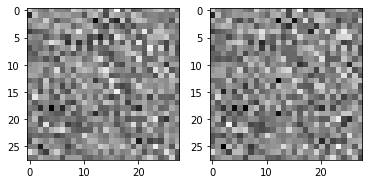

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

[10704.548]


In [19]:
def test_loss_fn():
  loss_ = []
  huber_loss_ = []
  huber_loss_weighted = []
  imp_weight_ = []
  model_huber_loss = []
  for i in range(1, timesteps):
    tt = jnp.array([i])
    data_noisy_temp, noise_temp = get_noisy(subkeys[i-1], b, tt)
    loss_.append(jax.device_get(compute_loss(avg_params, [data_noisy_temp[0:1], l[0:1], tt, 
                                                          noise_temp[0:1]], False)))
    huber_loss__ = huber_loss(data_noisy_temp[0:2], b[0:2])
    huber_loss_.append(huber_loss__)
    
    imp_weight = 1/2 * (1/sigma_squared_q_t_corrected[tt]) * ((betas[tt])**2 / (variance[tt] * alphas[tt]))
    # loss on prediction
    huber_loss_weighted.append(jnp.sum(jnp.multiply(imp_weight, huber_loss__)))
    imp_weight_.append(imp_weight)
    
    pp = net.apply(avg_params, data_noisy_temp[0:1], tt, l[0:1])
    model_huber_loss.append(huber_loss(pp[0:1], noise_temp[0:1]))
    
  print(show_predicted_image(data_noisy_temp[0:1], avg_params, i, l[0:1]))
  return loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss
  
loss_, huber_loss_, huber_loss_weighted, imp_weight_, model_huber_loss = test_loss_fn()

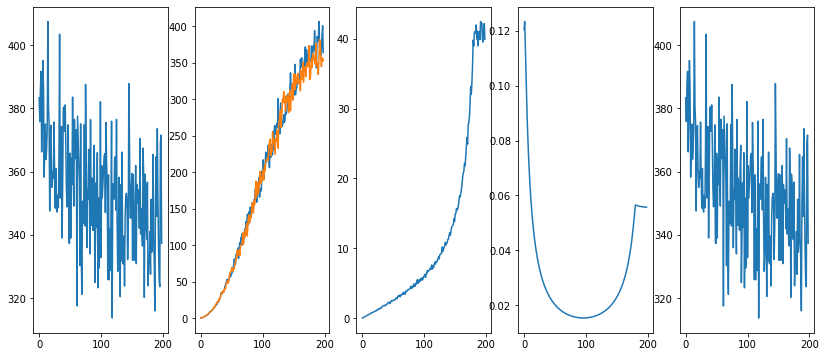

In [20]:
_, (plt1, plt2, plt3, plt4, plt5) = plt.subplots(1,5, figsize=(14, 6))

plt1.plot(loss_)
plt2.plot(huber_loss_)
plt3.plot(huber_loss_weighted)
plt4.plot(imp_weight_)
plt5.plot(model_huber_loss)

In [21]:
from copy import deepcopy
import pickle
import sys

batches_iter = 10000

def train_model(opt_state, params, avg_params, model_name, train_new_model=False, energy_method=False):
    best_loss = sys.float_info.max # initialization
        

    if train_new_model or not os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        # generating sub keys for timesteps
        unique_key = jax.random.fold_in(key, batch_size)
        
        # same subkey being used for noise sampling, as it doesn't matter :)
        _, *timestep_subkeys = jax.random.split(unique_key, batches_iter+1)
        
        losses = []
        for iteration in range(0, batches_iter):
            data_in_batch, label = next(train)
            data_in_batch = normalize(data_in_batch)
            idx = (jax.random.uniform(key=timestep_subkeys[iteration], shape=(batch_size, 1)) * (timesteps-1)).astype(int)
            idx = einops.rearrange(idx, 'a b -> (a b)')
            timestep = idx + 1
            data_noisy, noise = get_noisy(timestep_subkeys[iteration], data_in_batch, timestep)
            # todo: call gradient update function here
            loss_value, params, opt_state = update(params, opt_state, [data_noisy, label, timestep, noise], energy_method)
            avg_params = ema_update(params, avg_params)
            
            if iteration % 10 == 0:
              print("batch loss value: ", loss_value)
            
            if iteration % 50 == 0:                
                ## evaluating noise on a fixed timestep to calculate best model
                one_timestep = jnp.mod(jnp.arange(1, batch_size+1), timesteps)
                data_noisy_temp, noise_temp = get_noisy(timestep_subkeys[iteration], data_in_batch, one_timestep)
                loss_temp = jax.device_get(compute_loss(avg_params, [data_noisy_temp, label, one_timestep, noise_temp], energy_method))
                losses.append(loss_temp)
            
                if loss_temp < best_loss:
                    best_loss = loss_temp
                    print(f"saving iteration: {iteration} loss: {best_loss:>7f}")
                    save(model_paths, avg_params, model_name)
                    write_cached([data_noisy, data_in_batch, timestep, losses], osp.join(data_paths, model_name + '_state.pt'))
                    # sample a random number
                    r_ = (jax.random.uniform(timestep_subkeys[iteration])*batch_size).astype(int)
                    show_predicted_image(data_noisy_temp[r_: r_+1], avg_params, one_timestep[r_], label[r_: r_+1])
            
                if iteration % 100 == 0:
                    print(f"iteration: {iteration} loss: {loss_temp:>7f}")

    if os.path.exists(osp.join(data_paths, model_name + '_state.pt')):
        avg_params = restore(model_paths, model_name)
        data_noisy, data_in_batch, timestep, losses = load_cached(osp.join(data_paths, model_name + '_state.pt')) 
    return data_noisy, data_in_batch, timestep, losses, avg_params

batch loss value:  184424.08
saving iteration: 0 loss: 465422.125000
time step for image 19


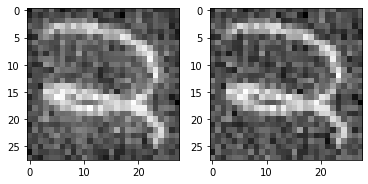

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 0 loss: 465422.125000
batch loss value:  60350.74
batch loss value:  38474.453
batch loss value:  32559.617
batch loss value:  26339.926
batch loss value:  23953.656
saving iteration: 50 loss: 26593.101562
time step for image 137


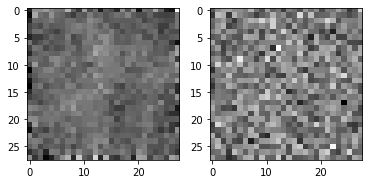

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  22090.96
batch loss value:  20200.832
batch loss value:  18595.5
batch loss value:  18554.363
batch loss value:  16611.25
saving iteration: 100 loss: 19249.173828
time step for image 86


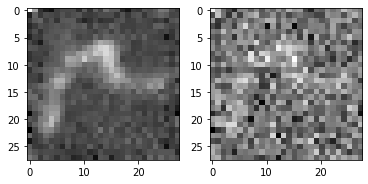

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 100 loss: 19249.173828
batch loss value:  16962.477
batch loss value:  16934.594
batch loss value:  15337.053
batch loss value:  13667.628
batch loss value:  13647.484
saving iteration: 150 loss: 15862.772461
time step for image 60


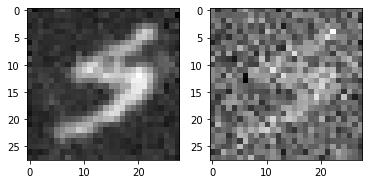

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  14730.831
batch loss value:  13936.199
batch loss value:  11979.621
batch loss value:  12690.238
batch loss value:  12824.986
saving iteration: 200 loss: 13828.220703
time step for image 193


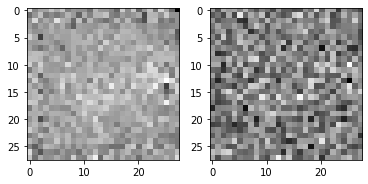

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 200 loss: 13828.220703
batch loss value:  11378.691
batch loss value:  11604.191
batch loss value:  11528.324
batch loss value:  9711.981
batch loss value:  10381.875
saving iteration: 250 loss: 12041.657227
time step for image 98


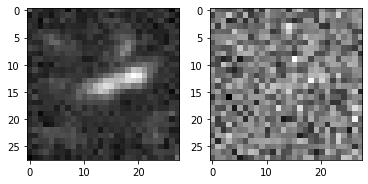

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  9581.7705
batch loss value:  10039.516
batch loss value:  10871.831
batch loss value:  9315.592
batch loss value:  9763.164
saving iteration: 300 loss: 11456.388672
time step for image 56


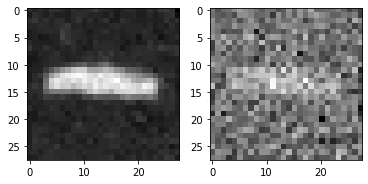

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 300 loss: 11456.388672
batch loss value:  10934.75
batch loss value:  9651.675
batch loss value:  10261.146
batch loss value:  9498.645
batch loss value:  8743.502
saving iteration: 350 loss: 10485.759766
time step for image 1


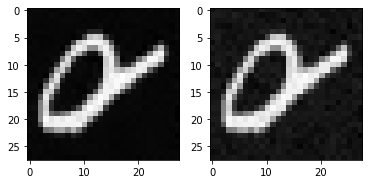

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  9011.294
batch loss value:  9950.742
batch loss value:  8848.765
batch loss value:  9032.973
batch loss value:  8034.0977
saving iteration: 400 loss: 9957.787109
time step for image 154


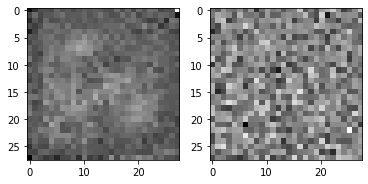

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 400 loss: 9957.787109
batch loss value:  7834.4727
batch loss value:  8828.146
batch loss value:  9567.267
batch loss value:  8199.148
batch loss value:  8556.742
saving iteration: 450 loss: 9784.691406
time step for image 16


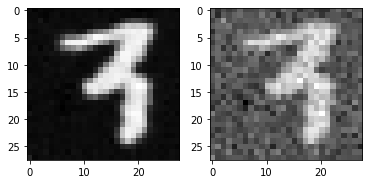

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  8399.435
batch loss value:  8819.604
batch loss value:  7816.44
batch loss value:  7880.7764
batch loss value:  8614.746
saving iteration: 500 loss: 9456.561523
time step for image 138


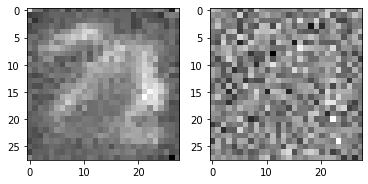

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 500 loss: 9456.561523
batch loss value:  8844.338
batch loss value:  8196.723
batch loss value:  8291.82
batch loss value:  8832.048
batch loss value:  8230.911
saving iteration: 550 loss: 9275.656250
time step for image 113


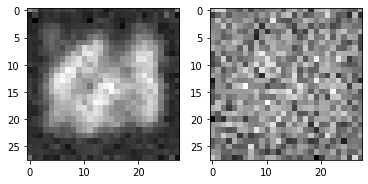

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  8174.6143
batch loss value:  7928.5195
batch loss value:  8665.803
batch loss value:  7949.957
batch loss value:  7235.283
saving iteration: 600 loss: 8951.799805
time step for image 89


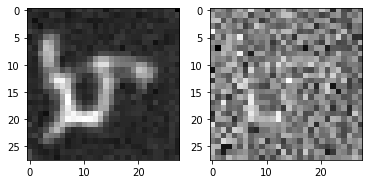

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 600 loss: 8951.799805
batch loss value:  7646.9395
batch loss value:  7967.009
batch loss value:  7526.8027
batch loss value:  7734.905
batch loss value:  7614.83
batch loss value:  7674.8027
batch loss value:  7926.0005
batch loss value:  7893.294
batch loss value:  7540.451
batch loss value:  7929.5283
saving iteration: 700 loss: 8694.591797
time step for image 61


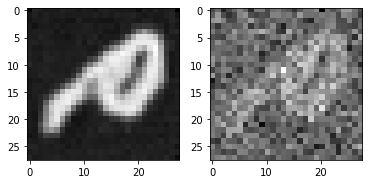

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 700 loss: 8694.591797
batch loss value:  8382.006
batch loss value:  8089.318
batch loss value:  7909.4697
batch loss value:  8142.7246
batch loss value:  8154.637
batch loss value:  7830.9375
batch loss value:  7570.5557
batch loss value:  8046.5166
batch loss value:  7517.5405
batch loss value:  7412.4424
iteration: 800 loss: 8865.859375
batch loss value:  7683.1865
batch loss value:  7621.1987
batch loss value:  7770.0713
batch loss value:  6830.6216
batch loss value:  7664.169
saving iteration: 850 loss: 8527.900391
time step for image 42


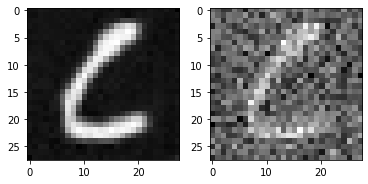

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  7738.381
batch loss value:  7621.6187
batch loss value:  7488.8525
batch loss value:  7431.1426
batch loss value:  7335.974
saving iteration: 900 loss: 8517.144531
time step for image 176


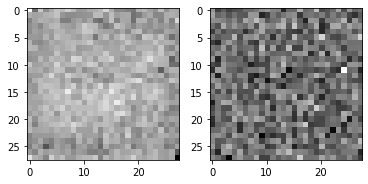

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 900 loss: 8517.144531
batch loss value:  7468.5547
batch loss value:  7611.2695
batch loss value:  7112.804
batch loss value:  7740.0913
batch loss value:  7450.5234
batch loss value:  7610.2686
batch loss value:  7460.532
batch loss value:  6881.9453
batch loss value:  7628.6055
batch loss value:  7601.4893
saving iteration: 1000 loss: 8443.427734
time step for image 58


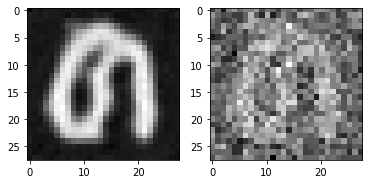

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 1000 loss: 8443.427734
batch loss value:  7224.883
batch loss value:  7017.834
batch loss value:  6807.574
batch loss value:  6797.1133
batch loss value:  7130.385
saving iteration: 1050 loss: 8153.373047
time step for image 11


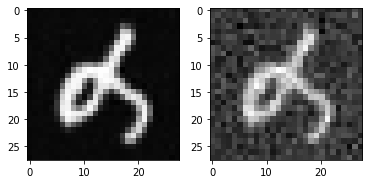

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6611.1826
batch loss value:  7242.6675
batch loss value:  7406.6885
batch loss value:  6684.5347
batch loss value:  6951.7725
iteration: 1100 loss: 8365.560547
batch loss value:  7698.029
batch loss value:  7049.9785
batch loss value:  7850.04
batch loss value:  7521.4966
batch loss value:  6637.084
saving iteration: 1150 loss: 8132.749512
time step for image 173


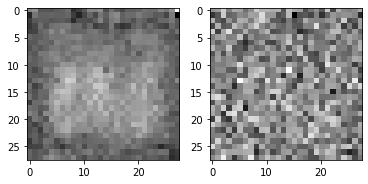

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6956.127
batch loss value:  7202.6143
batch loss value:  7225.3965
batch loss value:  7279.0396
batch loss value:  7743.332
iteration: 1200 loss: 8145.111816
batch loss value:  7122.047
batch loss value:  7088.62
batch loss value:  6660.5938
batch loss value:  7000.3545
batch loss value:  6786.6445
batch loss value:  6692.6113
batch loss value:  6716.495
batch loss value:  6828.832
batch loss value:  6578.592
batch loss value:  6758.7954
saving iteration: 1300 loss: 7994.981445
time step for image 71


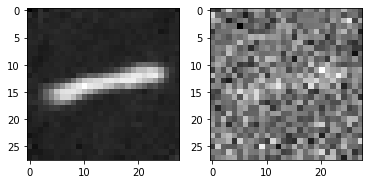

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 1300 loss: 7994.981445
batch loss value:  6726.408
batch loss value:  6113.332
batch loss value:  7155.533
batch loss value:  7367.5537
batch loss value:  7004.468
batch loss value:  6885.8926
batch loss value:  7337.374
batch loss value:  7011.7515
batch loss value:  6516.49
batch loss value:  6689.008
saving iteration: 1400 loss: 7880.598633
time step for image 29


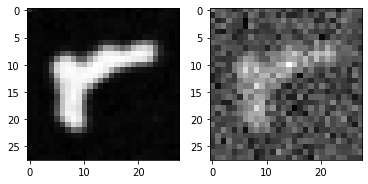

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 1400 loss: 7880.598633
batch loss value:  7306.5
batch loss value:  6562.4937
batch loss value:  6188.456
batch loss value:  6858.9497
batch loss value:  7680.8047
batch loss value:  7050.4424
batch loss value:  7619.039
batch loss value:  6947.6396
batch loss value:  6821.6943
batch loss value:  6914.3867
saving iteration: 1500 loss: 7578.791992
time step for image 52


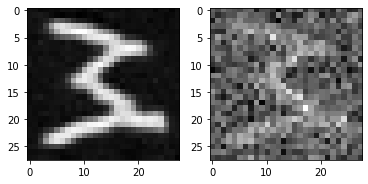

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 1500 loss: 7578.791992
batch loss value:  6875.8345
batch loss value:  5857.767
batch loss value:  6858.13
batch loss value:  6498.559
batch loss value:  6964.789
batch loss value:  6677.032
batch loss value:  7185.6123
batch loss value:  7093.659
batch loss value:  7762.6226
batch loss value:  6652.625
iteration: 1600 loss: 7718.790039
batch loss value:  6850.146
batch loss value:  6452.664
batch loss value:  6458.3228
batch loss value:  6401.448
batch loss value:  6881.626
batch loss value:  6126.035
batch loss value:  6392.5654
batch loss value:  6989.961
batch loss value:  6917.1123
batch loss value:  7061.14
iteration: 1700 loss: 7806.049805
batch loss value:  6289.9805
batch loss value:  7102.909
batch loss value:  6779.492
batch loss value:  6718.3896
batch loss value:  6939.835
batch loss value:  6326.96
batch loss value:  6366.176
batch loss value:  6887.1406
batch loss value:  7205.8896
batch loss value:  6773.7427
iteration: 1800 loss: 7591.145508
batch loss value

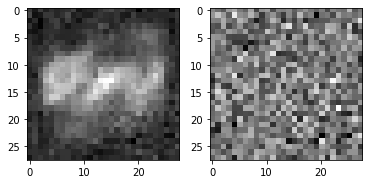

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 2000 loss: 7519.346191
batch loss value:  6724.9087
batch loss value:  6765.33
batch loss value:  6689.854
batch loss value:  6809.226
batch loss value:  6362.96
batch loss value:  6972.6553
batch loss value:  6325.1167
batch loss value:  6360.713
batch loss value:  6751.7725
batch loss value:  6886.62
saving iteration: 2100 loss: 7285.114258
time step for image 15


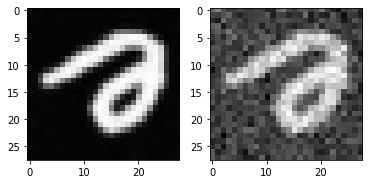

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 2100 loss: 7285.114258
batch loss value:  6278.9043
batch loss value:  6361.702
batch loss value:  6667.6875
batch loss value:  6485.966
batch loss value:  6266.0283
batch loss value:  6377.0312
batch loss value:  6395.562
batch loss value:  6498.2344
batch loss value:  6437.7373
batch loss value:  5929.746
saving iteration: 2200 loss: 7175.500000
time step for image 142


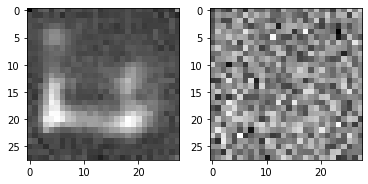

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 2200 loss: 7175.500000
batch loss value:  5749.0034
batch loss value:  6212.5957
batch loss value:  6197.2163
batch loss value:  6523.1074
batch loss value:  6806.0293
batch loss value:  6352.4614
batch loss value:  6703.0137
batch loss value:  6843.2246
batch loss value:  6622.016
batch loss value:  6511.497
iteration: 2300 loss: 7369.056152
batch loss value:  6526.3145
batch loss value:  6202.909
batch loss value:  6124.2285
batch loss value:  6480.2783
batch loss value:  6407.3184
batch loss value:  6182.331
batch loss value:  6721.838
batch loss value:  6297.1787
batch loss value:  6606.6743
batch loss value:  6753.9985
iteration: 2400 loss: 7399.836426
batch loss value:  6290.341
batch loss value:  5978.0117
batch loss value:  5819.9727
batch loss value:  6856.544
batch loss value:  5943.9463
saving iteration: 2450 loss: 7129.451172
time step for image 45


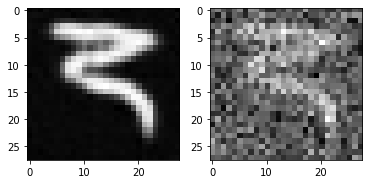

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6003.705
batch loss value:  6197.259
batch loss value:  6362.4717
batch loss value:  6202.9707
batch loss value:  6454.4697
iteration: 2500 loss: 7532.876953
batch loss value:  6331.8223
batch loss value:  6048.9863
batch loss value:  5749.288
batch loss value:  6369.2495
batch loss value:  6510.33
batch loss value:  6130.4443
batch loss value:  6054.2007
batch loss value:  6114.8896
batch loss value:  6668.0605
batch loss value:  6052.5947
iteration: 2600 loss: 7346.059082
batch loss value:  6436.468
batch loss value:  6199.1304
batch loss value:  6057.241
batch loss value:  6574.703
batch loss value:  6528.3135
batch loss value:  6154.589
batch loss value:  5826.3096
batch loss value:  6264.663
batch loss value:  6343.839
batch loss value:  6443.2236
saving iteration: 2700 loss: 7124.795898
time step for image 146


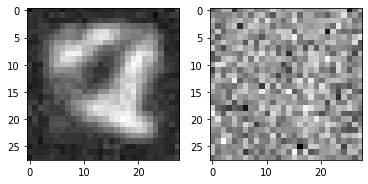

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 2700 loss: 7124.795898
batch loss value:  6310.292
batch loss value:  6734.5146
batch loss value:  6207.273
batch loss value:  6074.7246
batch loss value:  6254.588
saving iteration: 2750 loss: 7103.562988
time step for image 32


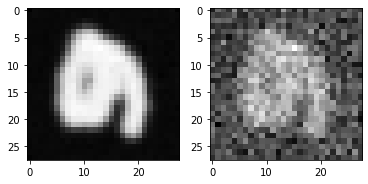

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5570.291
batch loss value:  6224.722
batch loss value:  6598.891
batch loss value:  6251.5615
batch loss value:  6387.7256
saving iteration: 2800 loss: 7021.070312
time step for image 15


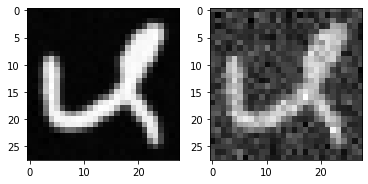

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 2800 loss: 7021.070312
batch loss value:  6486.451
batch loss value:  6154.642
batch loss value:  6203.0796
batch loss value:  6072.841
batch loss value:  6076.4307
saving iteration: 2850 loss: 7018.263672
time step for image 80


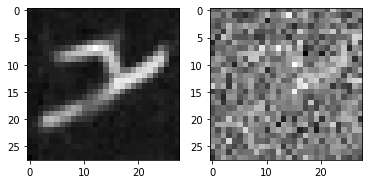

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5958.037
batch loss value:  5667.3965
batch loss value:  6097.069
batch loss value:  6250.745
batch loss value:  6104.121
iteration: 2900 loss: 7156.984863
batch loss value:  6199.5557
batch loss value:  6100.2803
batch loss value:  5896.6274
batch loss value:  5954.047
batch loss value:  6076.405
saving iteration: 2950 loss: 6885.845703
time step for image 1


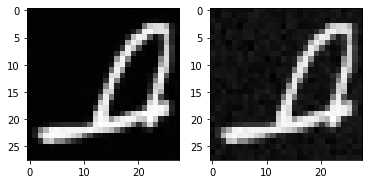

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6310.505
batch loss value:  5824.7227
batch loss value:  6394.959
batch loss value:  6329.277
batch loss value:  6029.6626
iteration: 3000 loss: 6983.905273
batch loss value:  5663.672
batch loss value:  6075.801
batch loss value:  5909.4307
batch loss value:  6389.8306
batch loss value:  5628.291
batch loss value:  5986.862
batch loss value:  6460.9233
batch loss value:  6299.752
batch loss value:  5608.388
batch loss value:  6312.1655
iteration: 3100 loss: 6967.911133
batch loss value:  5504.7314
batch loss value:  6054.593
batch loss value:  6239.9497
batch loss value:  6123.8975
batch loss value:  5844.128
saving iteration: 3150 loss: 6830.664551
time step for image 36


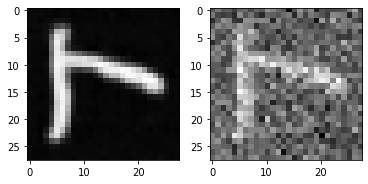

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  6466.9463
batch loss value:  6049.4785
batch loss value:  5991.1157
batch loss value:  6124.8066
batch loss value:  5808.6636
saving iteration: 3200 loss: 6741.366211
time step for image 178


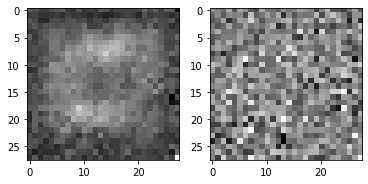

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 3200 loss: 6741.366211
batch loss value:  6196.0684
batch loss value:  5756.0
batch loss value:  5908.249
batch loss value:  6179.359
batch loss value:  5997.777
batch loss value:  6008.5967
batch loss value:  5921.5947
batch loss value:  5500.542
batch loss value:  6669.3203
batch loss value:  5961.283
iteration: 3300 loss: 7024.657227
batch loss value:  6186.5957
batch loss value:  5734.335
batch loss value:  5815.938
batch loss value:  5850.533
batch loss value:  5767.0596
batch loss value:  6492.105
batch loss value:  6273.433
batch loss value:  5683.943
batch loss value:  6103.7104
batch loss value:  6015.421
saving iteration: 3400 loss: 6529.661133
time step for image 100


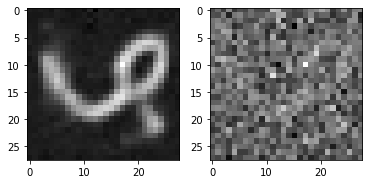

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 3400 loss: 6529.661133
batch loss value:  6026.005
batch loss value:  6089.7266
batch loss value:  6079.247
batch loss value:  6146.826
batch loss value:  6479.4414
batch loss value:  6205.8643
batch loss value:  5827.287
batch loss value:  5812.3716
batch loss value:  6601.0454
batch loss value:  6099.0356
iteration: 3500 loss: 6971.041504
batch loss value:  5679.2246
batch loss value:  5909.865
batch loss value:  6077.282
batch loss value:  6288.329
batch loss value:  6246.1177
batch loss value:  6362.8955
batch loss value:  5965.0215
batch loss value:  6818.5645
batch loss value:  5798.718
batch loss value:  5560.586
iteration: 3600 loss: 6601.132324
batch loss value:  5679.286
batch loss value:  5879.4326
batch loss value:  5646.2075
batch loss value:  6414.4688
batch loss value:  5947.8447
batch loss value:  6236.938
batch loss value:  5941.156
batch loss value:  6173.0913
batch loss value:  5691.1846
batch loss value:  5807.548
iteration: 3700 loss: 6630.482910
batch l

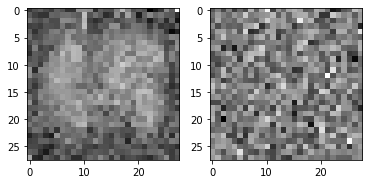

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5843.7734
batch loss value:  5817.2114
batch loss value:  5629.226
batch loss value:  5986.755
batch loss value:  6195.163
iteration: 3900 loss: 6965.837891
batch loss value:  6315.907
batch loss value:  5881.2285
batch loss value:  5935.9272
batch loss value:  5928.712
batch loss value:  6276.9414
batch loss value:  6201.549
batch loss value:  6286.5205
batch loss value:  5572.6094
batch loss value:  5527.433
batch loss value:  5449.04
iteration: 4000 loss: 6810.966797
batch loss value:  6322.657
batch loss value:  5827.8184
batch loss value:  5387.427
batch loss value:  5787.4204
batch loss value:  6568.526
batch loss value:  5276.6523
batch loss value:  5717.4824
batch loss value:  6220.162
batch loss value:  5640.816
batch loss value:  5846.904
iteration: 4100 loss: 6599.888672
batch loss value:  6171.9927
batch loss value:  6047.825
batch loss value:  5292.5244
batch loss value:  5725.638
batch loss value:  5873.946
batch loss value:  5507.6367
batch loss value:

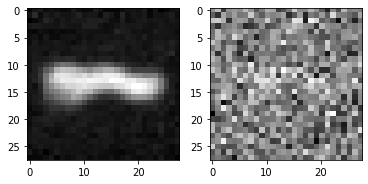

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5625.88
batch loss value:  6020.4453
batch loss value:  6001.0117
batch loss value:  5910.2207
batch loss value:  6003.921
iteration: 4300 loss: 6762.125000
batch loss value:  6076.7285
batch loss value:  5859.737
batch loss value:  5946.2573
batch loss value:  6052.3906
batch loss value:  6214.445
batch loss value:  5983.589
batch loss value:  5624.459
batch loss value:  6142.9785
batch loss value:  5768.1143
batch loss value:  5171.493
saving iteration: 4400 loss: 6445.997559
time step for image 108


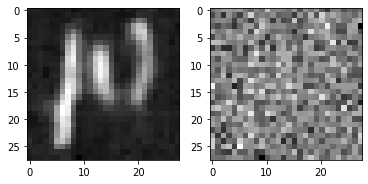

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 4400 loss: 6445.997559
batch loss value:  5881.762
batch loss value:  5494.255
batch loss value:  5640.953
batch loss value:  6222.409
batch loss value:  5974.4814
batch loss value:  5850.6533
batch loss value:  5956.6465
batch loss value:  6182.46
batch loss value:  6334.9277
batch loss value:  5889.089
iteration: 4500 loss: 6796.350098
batch loss value:  6059.456
batch loss value:  5291.8057
batch loss value:  5943.5664
batch loss value:  5664.593
batch loss value:  6161.753
batch loss value:  5490.206
batch loss value:  5880.283
batch loss value:  5921.707
batch loss value:  5723.153
batch loss value:  5980.193
iteration: 4600 loss: 6655.263672
batch loss value:  5372.4746
batch loss value:  5816.5674
batch loss value:  5537.531
batch loss value:  5635.091
batch loss value:  5577.266
batch loss value:  5599.308
batch loss value:  5974.0596
batch loss value:  6228.8696
batch loss value:  5736.54
batch loss value:  5453.8594
iteration: 4700 loss: 6494.447266
batch loss valu

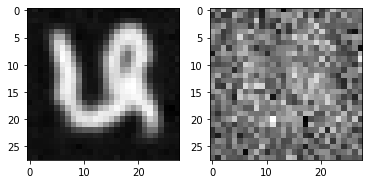

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5460.05
batch loss value:  5475.562
batch loss value:  6133.181
batch loss value:  5743.4844
batch loss value:  6321.228
iteration: 4800 loss: 6629.410156
batch loss value:  5522.922
batch loss value:  5690.4507
batch loss value:  5426.624
batch loss value:  6051.3027
batch loss value:  6320.9004
batch loss value:  5816.0117
batch loss value:  5562.5835
batch loss value:  5223.7354
batch loss value:  5503.229
batch loss value:  5992.784
iteration: 4900 loss: 6581.966797
batch loss value:  5635.3174
batch loss value:  6202.7812
batch loss value:  5782.7627
batch loss value:  5595.372
batch loss value:  5443.8423
batch loss value:  5624.658
batch loss value:  5454.533
batch loss value:  5806.059
batch loss value:  6188.559
batch loss value:  5484.4478
iteration: 5000 loss: 6394.947754
batch loss value:  5479.1343
batch loss value:  5578.0625
batch loss value:  5490.874
batch loss value:  5784.3403
batch loss value:  6273.1235
batch loss value:  5647.499
batch loss valu

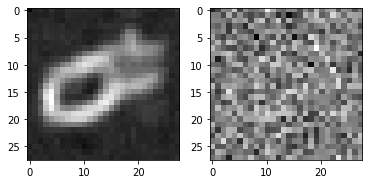

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5640.4844
batch loss value:  6007.913
batch loss value:  4971.331
batch loss value:  6234.6323
batch loss value:  5718.5596
iteration: 5200 loss: 6361.928223
batch loss value:  6026.6567
batch loss value:  5868.6494
batch loss value:  5870.0522
batch loss value:  5732.1875
batch loss value:  5711.9097
batch loss value:  6246.0576
batch loss value:  5145.878
batch loss value:  5627.3413
batch loss value:  5945.2646
batch loss value:  5557.968
iteration: 5300 loss: 6459.034180
batch loss value:  5654.997
batch loss value:  5675.1025
batch loss value:  5446.8857
batch loss value:  5401.931
batch loss value:  5589.7515
batch loss value:  5527.249
batch loss value:  6238.009
batch loss value:  5800.276
batch loss value:  5667.3037
batch loss value:  5614.4116
iteration: 5400 loss: 6447.894043
batch loss value:  5790.083
batch loss value:  5660.599
batch loss value:  6124.3203
batch loss value:  5698.8584
batch loss value:  5414.12
saving iteration: 5450 loss: 6242.146973


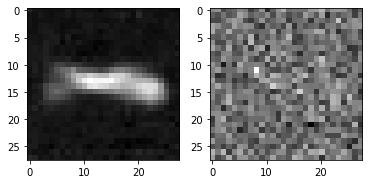

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

batch loss value:  5849.589
batch loss value:  5470.5396
batch loss value:  5372.443
batch loss value:  5780.7686
batch loss value:  6197.343
iteration: 5500 loss: 6524.995117
batch loss value:  5363.9814
batch loss value:  5233.33
batch loss value:  5408.047
batch loss value:  5596.1665
batch loss value:  5896.562
batch loss value:  5305.641
batch loss value:  5746.589
batch loss value:  5972.924
batch loss value:  5145.163
batch loss value:  5499.754
iteration: 5600 loss: 6361.163086
batch loss value:  5323.488
batch loss value:  6414.012
batch loss value:  5321.3115
batch loss value:  5594.055
batch loss value:  5954.979
batch loss value:  5442.499
batch loss value:  5810.4507
batch loss value:  5527.5713
batch loss value:  5330.254
batch loss value:  5982.8765
iteration: 5700 loss: 6526.189453
batch loss value:  5284.8403
batch loss value:  5434.17
batch loss value:  5330.388
batch loss value:  5806.1226
batch loss value:  5781.915
batch loss value:  5902.525
batch loss value:  526

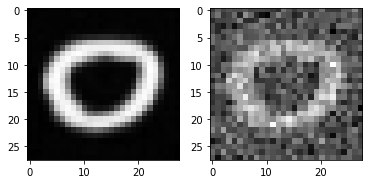

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 5900 loss: 6215.909668
batch loss value:  5176.674
batch loss value:  5885.2275
batch loss value:  5761.359
batch loss value:  5308.1143
batch loss value:  5841.147
batch loss value:  6116.164
batch loss value:  5872.874
batch loss value:  5612.2573
batch loss value:  5294.9736
batch loss value:  5635.617
iteration: 6000 loss: 6546.493164
batch loss value:  5738.125
batch loss value:  5333.4824
batch loss value:  5411.3105
batch loss value:  5947.834
batch loss value:  5310.2305
batch loss value:  5265.607
batch loss value:  5281.0186
batch loss value:  5296.6484
batch loss value:  5649.132
batch loss value:  5873.121
iteration: 6100 loss: 6494.062500
batch loss value:  5336.299
batch loss value:  5476.879
batch loss value:  5771.4834
batch loss value:  5563.8896
batch loss value:  5857.0054
batch loss value:  5325.032
batch loss value:  5254.28
batch loss value:  5285.8037
batch loss value:  5457.1914
batch loss value:  5465.454
saving iteration: 6200 loss: 6206.860352
time

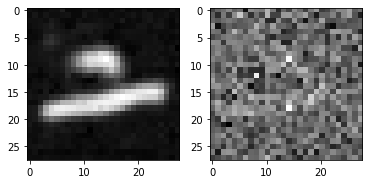

<Figure size 144x144 with 0 Axes>

<Figure size 144x144 with 0 Axes>

iteration: 6200 loss: 6206.860352
batch loss value:  5454.412
batch loss value:  5503.536
batch loss value:  5265.3555
batch loss value:  5306.163
batch loss value:  5517.637
batch loss value:  5344.5527
batch loss value:  6051.2793
batch loss value:  5316.74
batch loss value:  5635.7646
batch loss value:  5405.427
iteration: 6300 loss: 6413.836914
batch loss value:  5494.3955
batch loss value:  5294.996
batch loss value:  5340.704
batch loss value:  5471.861
batch loss value:  5559.0264
batch loss value:  5647.0503
batch loss value:  5249.09
batch loss value:  5602.124
batch loss value:  5352.1763
batch loss value:  5629.798
iteration: 6400 loss: 6411.675781
batch loss value:  5980.2646
batch loss value:  5147.0303
batch loss value:  5414.813
batch loss value:  5077.7754
batch loss value:  5387.1357
batch loss value:  4972.024
batch loss value:  5509.1494
batch loss value:  5635.662
batch loss value:  5669.1333
batch loss value:  5733.7695
iteration: 6500 loss: 6266.285156
batch loss 

In [ ]:
data_noisy, data_in_batch, timestep, losses, avg_params = train_model(opt_state, params, avg_params, model_name, train_new_model = train_new_model, energy_method=False)
plt.plot(losses)

In [ ]:
def param_count(pytree):
  return sum(x.size for x in jax.tree_util.tree_leaves(pytree))

param_count(avg_params)

## Full generation model

In [ ]:
mean_coeff_1 = jnp.sqrt(alphas)*(1 - alphas_prev_) / variance
mean_coeff_2 = jnp.sqrt(alphas_prev_) * betas / variance

In [ ]:
def generate_data(avg_params, energy_method=False, clipped_version=False, labels=None):
    batch_size_generation = 1
    unique_key = jax.random.fold_in(key, 0)
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, timesteps+1)
    
    # need to generate new keys everytime
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
    data_orig, label = next(train)
    data_orig = normalize(data_orig[0:batch_size_generation])
    label = label[0:batch_size_generation]
    data_noisy, _ = get_noisy(subkey, data_orig, jnp.array([timesteps]))
      
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy

    for t in range(1, timesteps+1):
        timestep = timesteps-t
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated, label)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas[timestep])) - jnp.log(sd[timestep]))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(alphas[timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas[timestep])/jnp.sqrt(alphas[timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 0:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)

        posterior_data = posterior_variance_corrected[timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch, data_orig

In [ ]:
datas, data_in_batch, data_orig = generate_data(avg_params, energy_method=False, clipped_version=True, labels="mixed")

In [ ]:
_, (plt1, plt2, plt3) = plt.subplots(1, 3)
show_image((data_in_batch[0]), plt1)
show_image((datas[0][0]), plt2)
show_image((data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
plt.plot([huber_loss(datas[i], data_orig) for i in range(len(datas))]) #, huber_loss(data_in_batch, data_orig), huber_loss(data_in_batch, datas[10])

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for data in datas:
    im = plt.imshow(data[0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_full_with_cond.gif', writer='pillow')

In [ ]:
with open(gifs_dir + 'diffusion_generation_full_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))

## strided sampling

In [ ]:
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L196
## https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L78
posterior_variance = (betas) * (1 - alphas_prev_) / (1 - alphas_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance[1], posterior_variance[1:]]))
posterior_variance_corrected = jnp.exp(log_posterior_variance)

strided_schedule = jnp.array(list(range(1, timesteps, 2)) + [timesteps])

alphas_strided_ = alphas_[strided_schedule]
alphas_prev_strided_ = jnp.pad(alphas_strided_[:-1], [1, 0], "constant", constant_values=1.0)

betas_strided = 1 - (alphas_strided_/alphas_prev_strided_)
posterior_variance_new_schedule = betas_strided * (1 - alphas_prev_strided_)/ (1-alphas_strided_)
log_posterior_variance = jnp.log(jnp.hstack([posterior_variance_new_schedule[1], posterior_variance_new_schedule[1:]]))
posterior_variance_new_schedule_corrected = jnp.exp(log_posterior_variance)

In [ ]:
mean_coeff_1 = jnp.sqrt(1-betas_strided)*(1 - alphas_prev_strided_) / (1 - alphas_strided_)
mean_coeff_2 = jnp.sqrt(alphas_prev_strided_) * betas_strided / (1 - alphas_strided_)

In [ ]:
def generate_data(avg_params, energy_method=False, clipped_version=False, labels=None):
    batch_size_generation = 1
    
    unique_key = jax.random.fold_in(key, 1)
    _, subkey = jax.random.split(unique_key)
    _, *subkeys = jax.random.split(unique_key, len(strided_schedule)+1)
    
    data_noisy = jax.random.normal(subkey, shape=(batch_size_generation, 28, 28, 1))
    data_orig, label = next(train)
    data_orig = normalize(data_orig[0:batch_size_generation])
    label = label[0:batch_size_generation]
    data_noisy, _ = get_noisy(subkey, data_orig, jnp.array([timesteps]))
          
    datas = []
    datas.append(jax.device_get(data_noisy))
    data_in_batch = data_noisy                               
    for t in range(1, len(strided_schedule)+1):
        stride_timestep = len(strided_schedule)-t
        timestep = strided_schedule[stride_timestep]
        t_repeated = jnp.repeat(jnp.array([timestep]), batch_size_generation)
        # data_stacked = torch.vstack([data_in_batch, labelled_values])
        pred_data = net.apply(avg_params, data_in_batch, t_repeated, label)
        if not clipped_version:
            if not energy_method:
                # optimization:: not sure if exp(log(x) - log(y)) instead of x/y helps numerically
                multiplier = jnp.exp(jnp.log((betas_strided[stride_timestep])) - jnp.log(jnp.sqrt(1- alphas_strided_[stride_timestep])))
                mean_data = jnp.subtract(data_in_batch, pred_data * multiplier)/jnp.sqrt(1-betas_strided[stride_timestep])
            else:
                ##
                # Energy function interpretation
                mean_data = jnp.add(data_in_batch, pred_data * betas_strided[stride_timestep])/jnp.sqrt(1-betas_strided[stride_timestep])
                ##
        else:
            # clipping an improvement as recommended in https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L171
            # this helps in improving the samples generated as it keeps the random variables in the range of -1 to +1
            if not energy_method:
                x_reconstructed = jnp.subtract(data_in_batch, pred_data * sd[timestep])/ jnp.sqrt(alphas_[timestep])
            else:
                # energy method and clipping to improve stabalization
                x_reconstructed = jnp.add(data_in_batch, pred_data * variance[timestep])/ jnp.sqrt(alphas_[timestep])

            if timestep >= 5:
                x_reconstructed = jnp.clip(x_reconstructed, 0., 1.)

            mean_data_1 = data_in_batch * mean_coeff_1[stride_timestep]
            mean_data_2 = x_reconstructed * mean_coeff_2[stride_timestep]
            mean_data = jnp.add(mean_data_1, mean_data_2)



        posterior_data = posterior_variance_new_schedule_corrected[stride_timestep]
        data_noisy = jax.random.normal(subkeys[t-1], shape=(batch_size_generation, 28, 28, 1))
        data_in_batch = jnp.add(mean_data,  jnp.sqrt(posterior_data) * data_noisy)
        datas.append(jax.device_get(data_in_batch))
    return datas, data_in_batch, data_orig

In [ ]:
datas, data_in_batch, data_orig = generate_data(avg_params, energy_method=False, clipped_version=True, labels="mixed")

In [ ]:
_, (plt1, plt2, plt3) = plt.subplots(1, 3)

show_image(unnormalize(data_in_batch[0]), plt1)
show_image(unnormalize(datas[0][0]), plt2)
show_image(unnormalize(data_orig[0]), plt3)

# data_noisy, _ = get_noisy(data_orig, jnp.array([60]))
# show_image(unnormalize(data_noisy[0]), plt1)

In [ ]:
huber_loss(datas[0], data_orig), huber_loss(data_in_batch, data_orig), huber_loss(data_in_batch, datas[50])

In [ ]:
%%capture 

fig = plt.figure()
ims = []

if colab:
  datas = einops.rearrange(datas, 'x b h w c -> x b h (w c)')
  
for data in datas:
    im = plt.imshow(data[0], cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=3000)
animate.save(gifs_dir + 'diffusion_generation_strided_with_cond.gif', writer='pillow')

In [ ]:
with open(gifs_dir + 'diffusion_generation_strided_with_cond.gif','rb') as f:
  display(Image(data=f.read(), format='png'))